# 06: Calibrate DMSP-OLS data

Following calibration here: https://worldbank.github.io/OpenNightLights/tutorials/mod5_1_DMSP-OLS_intercalibration.html#id3

In [70]:
import ee
import pandas as pd
import geemap
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [6]:
collection = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS").select('stable_lights')

In [97]:
lights_2007 = collection.filterDate('2007-01-01', '2007-12-31')

In [127]:
lights_2007.sort('system:index', False).first().getInfo()

{'type': 'Image',
 'bands': [{'id': 'stable_lights',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [43201, 16801],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0083333333,
    0,
    -180.00416666665,
    0,
    -0.0083333333,
    75.00416666665]}],
 'version': 1504844069669030.0,
 'id': 'NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F162007',
 'properties': {'system:time_start': 1167609600000,
  'system:time_end': 1199145600000,
  'system:asset_size': 1481938457,
  'system:index': 'F162007'}}

In [93]:
id = lights_2007.getInfo()['id']

In [94]:
id

'NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F152008'

In [77]:
id[-7:-4]

'F15'

In [78]:
calibration = pd.read_csv('../data/Elvidge_DMSP_intercalib_coef.csv')

In [79]:
calibration.loc[((calibration['satellite'] == "F15") & (calibration['year'] == 2007))]

,satellite,year,c0,c1,c2
23,F15,2007,1.3606,1.2974,-0.0045


In [80]:
calibration.head()

,satellite,year,c0,c1,c2
0,F10,1992,-2.0570,1.5903,-0.0090
1,F10,1993,-1.0582,1.5983,-0.0093
2,F10,1994,-0.3458,1.4864,-0.0079
3,F12,1994,-0.6890,1.1770,-0.0025
4,F12,1995,-0.0515,1.2293,-0.0038


In [50]:
def get_calib_coefficients(id, year):

    satellite = id[-7:-4]
    coefficient_df = calibration.loc[(calibration['satellite'] == satellite) & (calibration['year'] == year)].reset_index()

    return coefficient_df['c0'][0], coefficient_df['c1'][0], coefficient_df['c2'][0]

In [81]:
c0, c1, c2 = get_calib_coefficients(id, 2007)

In [82]:
c0

1.3606

In [83]:
c1

1.2974

In [84]:
c2

-0.0045

In [85]:
calibrated = lights_2007.expression(f'{c0} + ({c1} * X) + ({c2} * X * X)', {'X': lights_2007.select('stable_lights')})

# clip image

calibrated = calibrated.where(calibrated.gt(63),63).where(calibrated.lte(6),0)



In [86]:
lights_2007.getInfo()

{'type': 'Image',
 'bands': [{'id': 'stable_lights',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [43201, 16801],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0083333333,
    0,
    -180.00416666665,
    0,
    -0.0083333333,
    75.00416666665]}],
 'version': 1504844066942522,
 'id': 'NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F152007',
 'properties': {'system:time_start': 1167609600000,
  'system:time_end': 1199145600000,
  'system:asset_size': 1629231947,
  'system:index': 'F152007'}}

In [87]:
# define our rectangle that covers DC/Baltimore area
myPolyGeom = ee.Geometry.Rectangle([-78.243025, 38.317633,-75.724436, 39.521098]).toGeoJSON()

# convert both the clipped DMSP-OLS 1996 layer and the calibrated layer to numpy arrays
dmsp2007_arr = geemap.ee_to_numpy(lights_2007, region=myPolyGeom)
dmsp2007_clbr_arr = geemap.ee_to_numpy(calibrated, region=myPolyGeom)

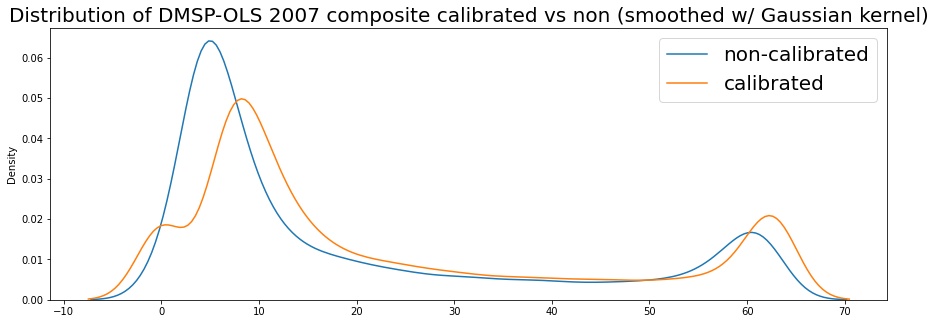

In [88]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmsp2007_arr.flatten(), label='non-calibrated',legend=True, ax=ax)
sns.kdeplot(dmsp2007_clbr_arr.flatten(), label='calibrated',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of DMSP-OLS 2007 composite calibrated vs non (smoothed w/ Gaussian kernel)', fontsize=20);

Cool, the calibrated curve looks like the F15 2007 curve in the tutorial.